In [1]:
# First, let's get all our tools ready
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Machine learning stuff we'll need
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Different models we want to try out
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier

# Just to keep things clean, ignore warnings
import warnings
warnings.filterwarnings('ignore')

print("Starting our crop recommendation project...")

Starting our crop recommendation project...


In [3]:
# We need to install xlrd to read Excel files
!pip install xlrd
print("xlrd installed for reading Excel files")

In [8]:
# Load the data exactly as you did - using read_csv for .xls file
crop = pd.read_csv("Crop_recommendation.xls")

print("✅ Data loaded successfully!")
print(f"Dataset Shape: {crop.shape}")
print(f"We have {crop.shape[0]} rows and {crop.shape[1]} columns")

print("\nFirst look at the data:")
print(crop.head())

print("\nChecking data quality...")
print("Missing values:")
print(crop.isnull().sum())

print(f"\nDuplicate rows: {crop.duplicated().sum()}")

print("\nWhat crops are we working with?")
print(crop['label'].value_counts())

✅ Data loaded successfully!
Dataset Shape: (2200, 8)
We have 2200 rows and 8 columns

First look at the data:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

Checking data quality...
Missing values:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Duplicate rows: 0

What crops are we working with?
label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         10

In [10]:
# Let's explore the data a bit more
print("Basic statistics:")
print(crop.describe())

print(f"\nWe have {crop['label'].nunique()} different crops to recommend")

Basic statistics:
                 N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000  
mean      6.469480   103.463655  
std       0.773938    54.958389  
min       3.504752    20.211267  
25%       5.971693    64.551686  
50%       6.425045    94.867624  
75%       6.923643   124.267508  
max       9.935091   298.560117  

We have 

In [9]:
crop.shape

(2200, 8)

In [11]:
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [13]:
crop.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [15]:
crop.duplicated().sum()

0

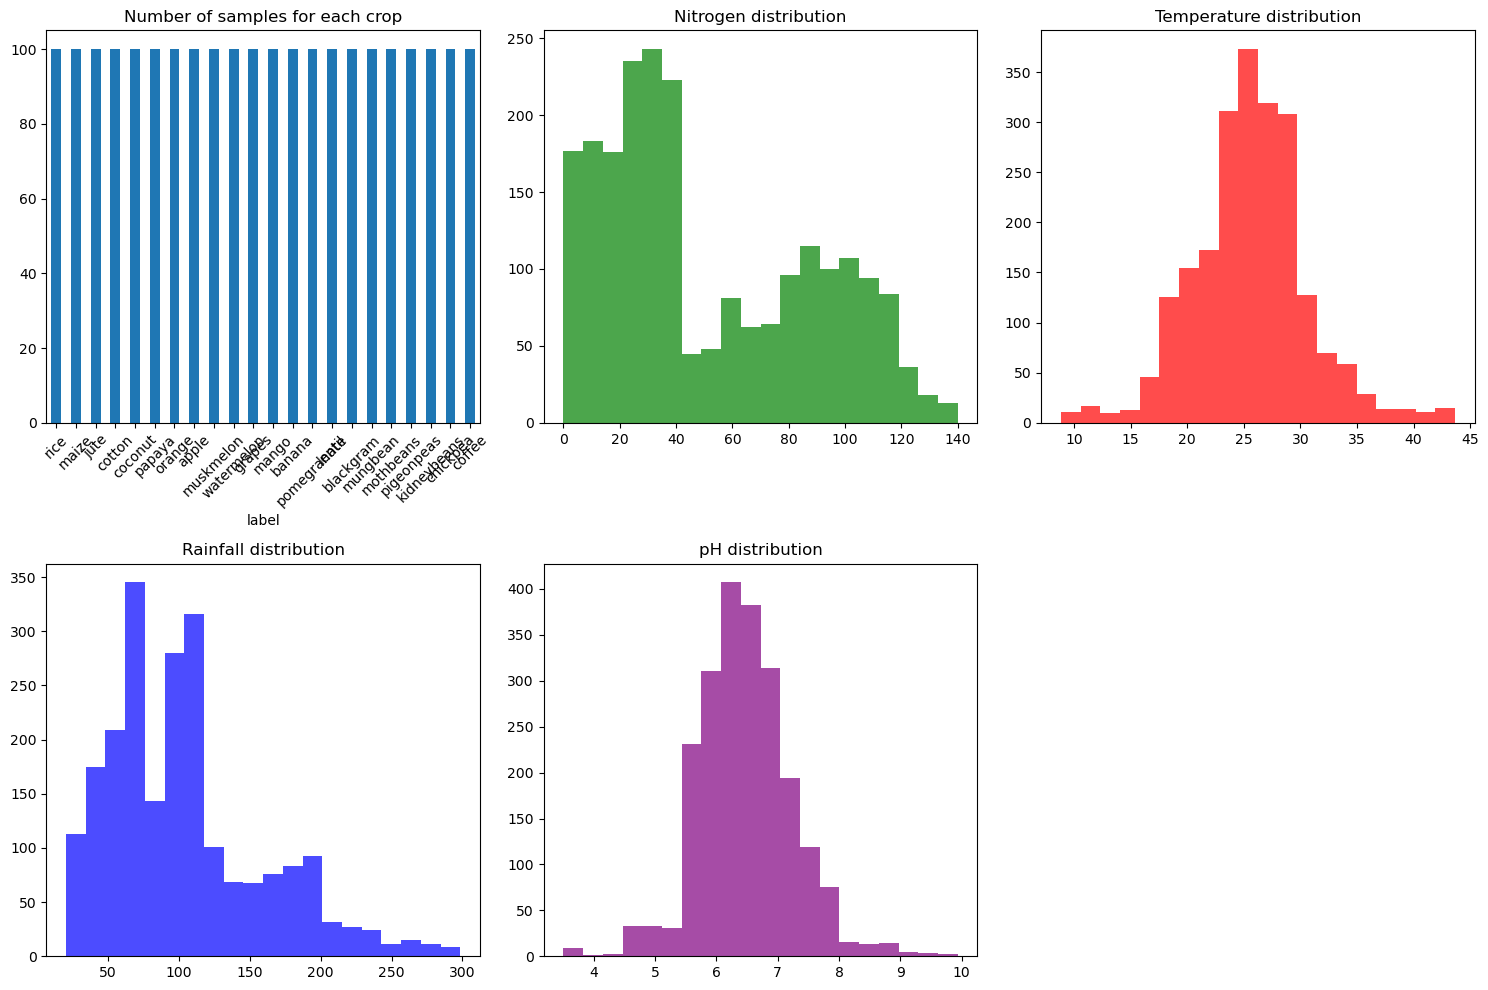

These plots help us understand the range of values for each feature


In [12]:
# Let's make some simple plots to understand our data
plt.figure(figsize=(15, 10))

# Plot 1: Crop distribution
plt.subplot(2, 3, 1)
crop['label'].value_counts().plot(kind='bar')
plt.title('Number of samples for each crop')
plt.xticks(rotation=45)

# Plot 2: Nitrogen distribution
plt.subplot(2, 3, 2)
plt.hist(crop['N'], bins=20, color='green', alpha=0.7)
plt.title('Nitrogen distribution')

# Plot 3: Temperature distribution
plt.subplot(2, 3, 3)
plt.hist(crop['temperature'], bins=20, color='red', alpha=0.7)
plt.title('Temperature distribution')

# Plot 4: Rainfall distribution
plt.subplot(2, 3, 4)
plt.hist(crop['rainfall'], bins=20, color='blue', alpha=0.7)
plt.title('Rainfall distribution')

# Plot 5: pH distribution
plt.subplot(2, 3, 5)
plt.hist(crop['ph'], bins=20, color='purple', alpha=0.7)
plt.title('pH distribution')

plt.tight_layout()
plt.show()

print("These plots help us understand the range of values for each feature")

In [14]:
# Create crop mapping
crop_dict = {
    "rice": 1, "maize": 2, "jute": 3, "cotton": 4, "coconut": 5,
    "papaya": 6, "orange": 7, "apple": 8, "muskmelon": 9, "watermelon": 10,
    "grapes": 11, "mango": 12, "banana": 13, "pomegranate": 14, "lentil": 15,
    "blackgram": 16, "mungbean": 17, "mothbeans": 18, "pigeonpeas": 19,
    "kidneybeans": 20, "chickpea": 21, "coffee": 22
}

# Add crop numbers
crop['crop_num'] = crop['label'].map(crop_dict)

print("Added numeric codes for crops:")
print(crop[['label', 'crop_num']].head(10))

Added numeric codes for crops:
  label  crop_num
0  rice         1
1  rice         1
2  rice         1
3  rice         1
4  rice         1
5  rice         1
6  rice         1
7  rice         1
8  rice         1
9  rice         1


<Axes: >

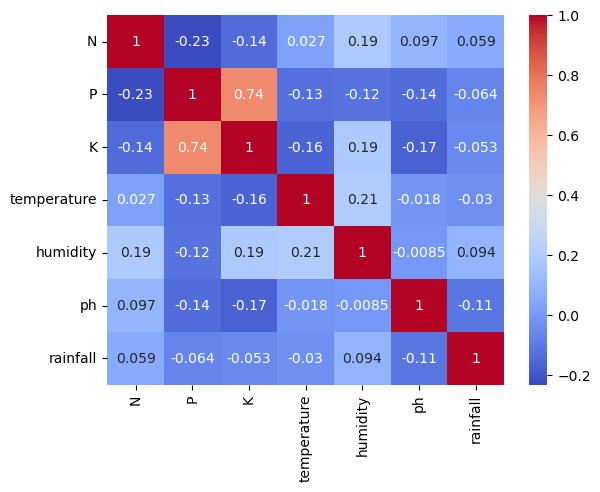

In [21]:
sns.heatmap(relation,annot=True,cbar=True,cmap='coolwarm')

In [16]:
# Prepare features and target
X = crop.drop(['label', 'crop_num'], axis=1)
y = crop['crop_num']

print("Features we're using:")
print(X.columns.tolist())
print(f"\nTarget: crop type ({y.nunique()} different crops)")

Features we're using:
['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

Target: crop type (22 different crops)


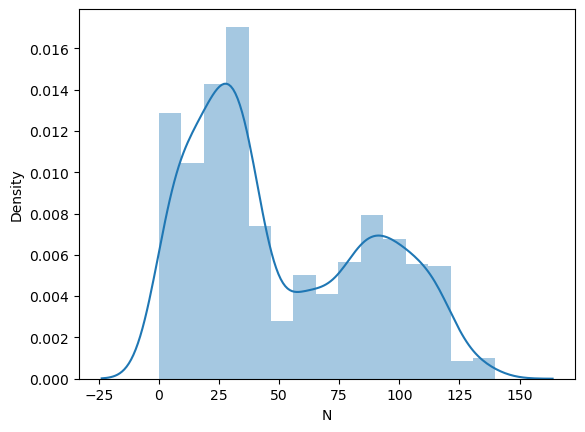

In [25]:
sns.distplot(crop['N'])
plt.show()

In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"That's {X_train.shape[0]/len(X)*100:.1f}% for training and {X_test.shape[0]/len(X)*100:.1f}% for testing")

Training set: 1760 samples
Testing set: 440 samples
That's 80.0% for training and 20.0% for testing


In [20]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data scaled successfully!")

Data scaled successfully!


In [31]:
crop.head()

,N,P,K,temperature,humidity,ph,rainfall,label,crop_num
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,1
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,1
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,1
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,1
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,1


In [33]:
crop = crop.drop(crop.columns[-2], axis=1)
crop.head()

,N,P,K,temperature,humidity,ph,rainfall,crop_num
0,90,42,43,20.879744,82.002744,6.502985,202.935536,1
1,85,58,41,21.770462,80.319644,7.038096,226.655537,1
2,60,55,44,23.004459,82.320763,7.840207,263.964248,1
3,74,35,40,26.491096,80.158363,6.980401,242.864034,1
4,78,42,42,20.130175,81.604873,7.628473,262.717340,1


In [23]:
# Let's test multiple models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42)
}

print("Training different models...")
print("=" * 50)

best_acc = 0
best_model = None
best_name = ""

for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    
    print(f"{name:20} → {acc * 100:6.2f}%")
    
    # Track best model
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_name = name

print("=" * 50)
print(f"🏆 Best model: {best_name} with {best_acc * 100:.2f}% accuracy")

Training different models...
Random Forest        →  99.77%
Decision Tree        →  98.18%
K-Neighbors          →  97.73%
Logistic Regression  →  97.50%
Naive Bayes          →  99.55%
SVM                  →  97.73%
Gradient Boosting    →  99.09%
AdaBoost             →  22.73%
Bagging              →  98.41%
Extra Trees          →  99.32%
🏆 Best model: Random Forest with 99.77% accuracy


Detailed analysis of Random Forest:

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00        20
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        20
          16       0.95      1.00      0.98        20
          17       1.

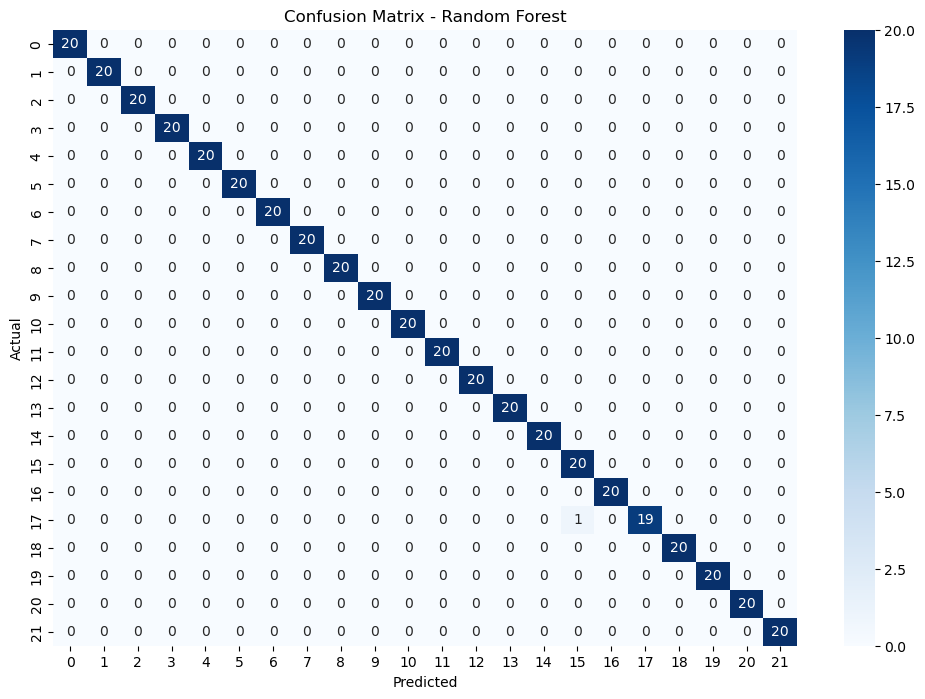

In [24]:
# Let's get more details about our best model
print(f"Detailed analysis of {best_name}:")
y_pred_best = best_model.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Confusion matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [27]:
# Create the crop recommendation function
def recommend_crop(N, P, K, temperature, humidity, ph, rainfall):
    # Prepare input
    features = np.array([[N, P, K, temperature, humidity, ph, rainfall]])
    
    # Scale it
    features_scaled = scaler.transform(features)
    
    # Predict
    crop_num = best_model.predict(features_scaled)[0]
    
    # Convert to crop name
    crop_dict_reverse = {v: k for k, v in crop_dict.items()}
    crop_name = crop_dict_reverse.get(crop_num, "Unknown")
    
    return crop_name

print("✅ Crop recommendation function created!")

✅ Crop recommendation function created!


In [29]:
# Test our function
print("Testing with some examples:")

# Example 1
test1 = recommend_crop(90, 42, 43, 20.87, 82.00, 6.50, 202.93)
print(f"Example 1 - Should be rice: {test1}")

# Example 2  
test2 = recommend_crop(104, 18, 30, 23.60, 60.39, 6.97, 140.93)
print(f"Example 2 - Should be coffee: {test2}")

# Example 3
test3 = recommend_crop(119, 15, 30, 26.33, 80.92, 6.28, 53.65)
print(f"Example 3 - Should be watermelon: {test3}")

print("\nAll tests completed!")

Testing with some examples:
Example 1 - Should be rice: rice
Example 2 - Should be coffee: coffee
Example 3 - Should be watermelon: watermelon

All tests completed!


In [31]:
# Save everything for the web app
pickle.dump(best_model, open('model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))

print("✅ model.pkl saved")
print("✅ scaler.pkl saved")
print("🎉 All done! Ready to build the web app!")

print(f"\nSummary:")
print(f"- Best model: {best_name}")
print(f"- Accuracy: {best_acc * 100:.2f}%")
print(f"- Training samples: {X_train.shape[0]}")
print(f"- Testing samples: {X_test.shape[0]}")
print(f"- Total crops: {len(crop_dict)}")

✅ model.pkl saved
✅ scaler.pkl saved
🎉 All done! Ready to build the web app!

Summary:
- Best model: Random Forest
- Accuracy: 99.77%
- Training samples: 1760
- Testing samples: 440
- Total crops: 22


In [33]:
import os

print("Checking for model files...")
files = os.listdir('.')
pkl_files = [f for f in files if f.endswith('.pkl')]

if 'model.pkl' in pkl_files and 'scaler.pkl' in pkl_files:
    print("✅ model.pkl found!")
    print("✅ scaler.pkl found!")
    print("🎯 Your files are ready for the Flask app!")
else:
    print("❌ Files missing. Let me create them...")
    # If missing, run your training code again

Checking for model files...
✅ model.pkl found!
✅ scaler.pkl found!
🎯 Your files are ready for the Flask app!
